In [3]:
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
import matplotlib
from timeit import default_timer

In [16]:
class GaussianRF(object):

    def __init__(self, dim, size, alpha=2, tau=3, sigma=None, boundary="periodic", device=None):

        self.dim = dim
        self.device = device

        if sigma is None:
            sigma = tau**(0.5*(2*alpha - self.dim))

        k_max = size//2

        if dim == 1:
            k = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                           torch.arange(start=-k_max, end=0, step=1, device=device)), 0)

            self.sqrt_eig = size*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0] = 0.0

        elif dim == 2:
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size,1)

            k_x = wavenumers.transpose(0,1)
            k_y = wavenumers

            self.sqrt_eig = (size**2)*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k_x**2 + k_y**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0,0] = 0.0

        elif dim == 3:
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size,size,1)

            k_x = wavenumers.transpose(1,2)
            k_y = wavenumers
            k_z = wavenumers.transpose(0,2)

            self.sqrt_eig = (size**3)*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k_x**2 + k_y**2 + k_z**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0,0,0] = 0.0

        self.size = []
        for j in range(self.dim):
            self.size.append(size)

        self.size = tuple(self.size)

    def sample(self, N):

        coeff = torch.randn(N, *self.size, 2, device=self.device)

        coeff[...,0] = self.sqrt_eig*coeff[...,0]
        coeff[...,1] = self.sqrt_eig*coeff[...,1]

        u = torch.fft.ifft(coeff, dim=self.dim, norm="forward").real
        u = u[...,0]

        return u

In [17]:
# Define parameters
dim = 2          # 2D field
size = 64        # 64x64 grid
alpha = 2        # Controls smoothness
tau = 3          # Spatial scale
N = 5            # Number of samples

# Create an instance of GaussianRF
grf = GaussianRF(dim=dim, size=size, alpha=alpha, tau=tau, device='cpu')

# Generate 5 samples
samples = grf.sample(N)


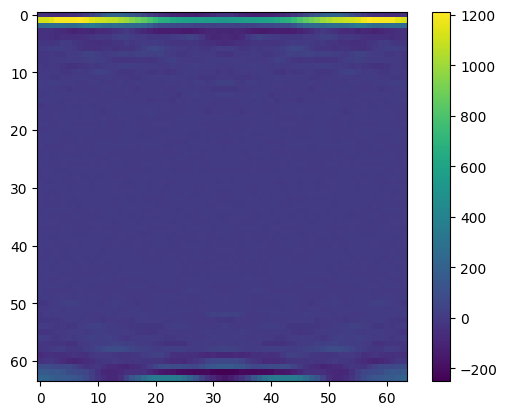

In [18]:
sample_to_plot = samples[0].resolve_conj().cpu().numpy()

plt.imshow(sample_to_plot, cmap='viridis')
plt.colorbar()
plt.show()